In [17]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import DBSCAN
from folium.plugins import MarkerCluster
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.cluster import MiniBatchKMeans


In [18]:
# 1. Import des données
# Charger le fichier CSV dans un DataFrame
df = pd.read_csv('2000_2021_SINGLE_TURKEY_FIRE_M_C61_214067.csv')

C:\Users\amaur\AppData\Local\Temp\ipykernel_21780\3377045064.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('2000_2021_SINGLE_TURKEY_FIRE_M_C61_214067.csv')


In [19]:
# 2. Analyse descriptive des données
# Afficher les premières lignes du DataFrame pour avoir un aperçu des données
print("Aperçu des données :")
print(df.head())

# Afficher les informations générales sur le DataFrame
print("\nInformations sur les données :")
print(df.info())

# Afficher les statistiques descriptives pour les variables quantitatives
print("\nStatistiques descriptives des variables quantitatives :")
print(df.describe())

Aperçu des données :
   latitude  longitude  brightness  scan  track    acq_date  acq_time  \
0   36.8527    35.3594       306.0   2.1    1.4  2000-11-01       815   
1   40.5441    35.1786       307.8   1.1    1.0  2000-11-02       857   
2   40.1473    35.0444       305.3   1.1    1.0  2000-11-02       857   
3   40.5421    35.1909       310.0   1.1    1.0  2000-11-02       857   
4   41.2569    31.4172       307.9   1.1    1.0  2000-11-02       857   

  satellite instrument  confidence version  bright_t31   frp daynight  type  
0     Terra      MODIS          60    6.03       294.4  13.2        D   0.0  
1     Terra      MODIS          66    6.03       296.0   5.8        D   0.0  
2     Terra      MODIS          46    6.03       293.5   4.3        D   0.0  
3     Terra      MODIS          69    6.03       296.1   7.3        D   0.0  
4     Terra      MODIS           0    6.03       290.4   8.0        D   2.0  

Informations sur les données :
<class 'pandas.core.frame.DataFrame'>
Ra

In [20]:
# 3. Nettoyage des données
# Vérifier les valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(df.isnull().sum())

# Supprimer les lignes avec des valeurs manquantes (si nécessaire)
df_cleaned = df.dropna()

# Vérifier les doublons
print("\nNombre de doublons :")
print(df.duplicated().sum())

# Supprimer les doublons (si nécessaire)
df_cleaned = df_cleaned.drop_duplicates()


Valeurs manquantes par colonne :
latitude         0
longitude        0
brightness       0
scan             0
track            0
acq_date         0
acq_time         0
satellite        0
instrument       0
confidence       0
version          0
bright_t31       0
frp              0
daynight         0
type          5391
dtype: int64

Nombre de doublons :
0


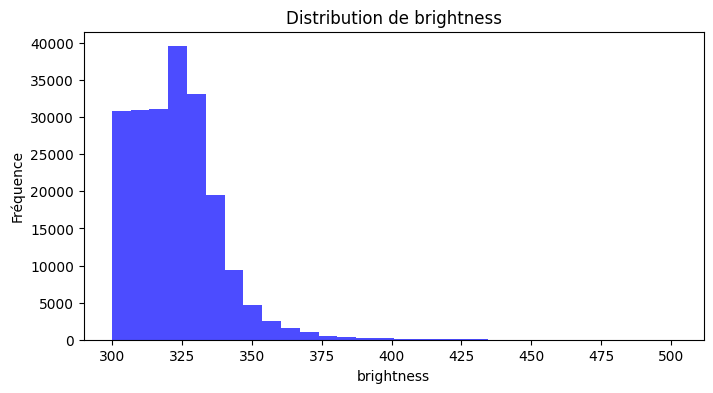

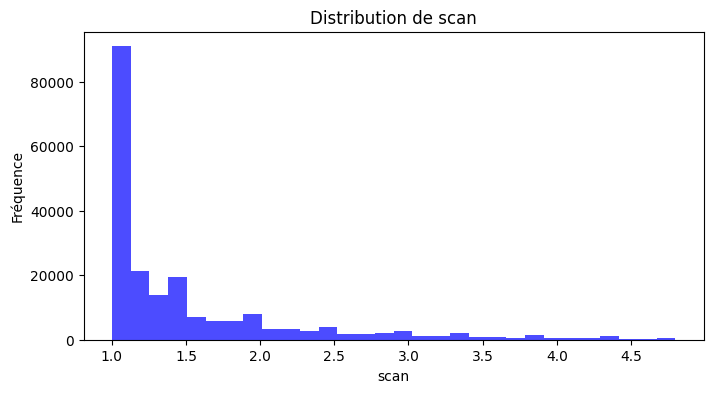

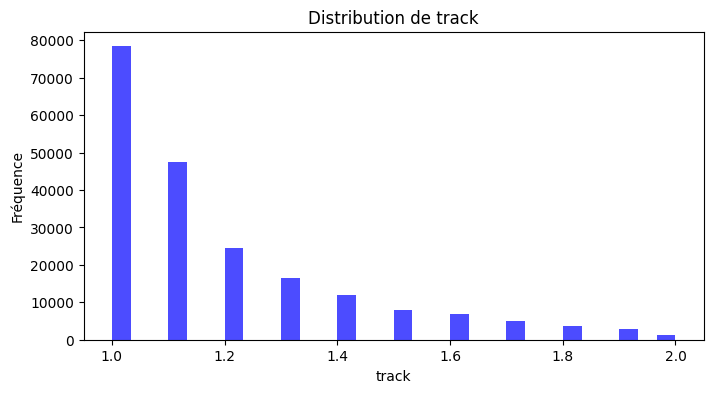

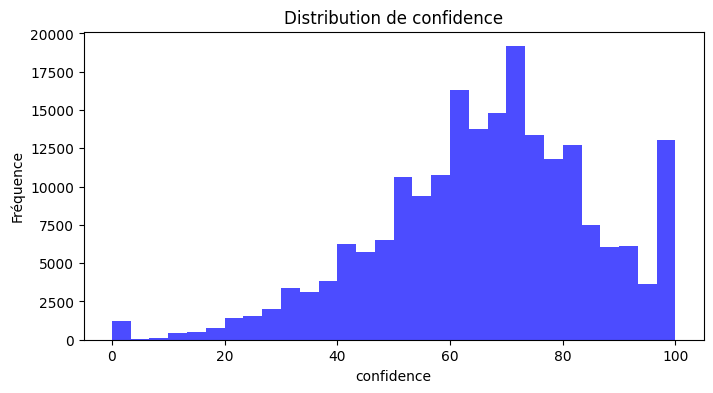

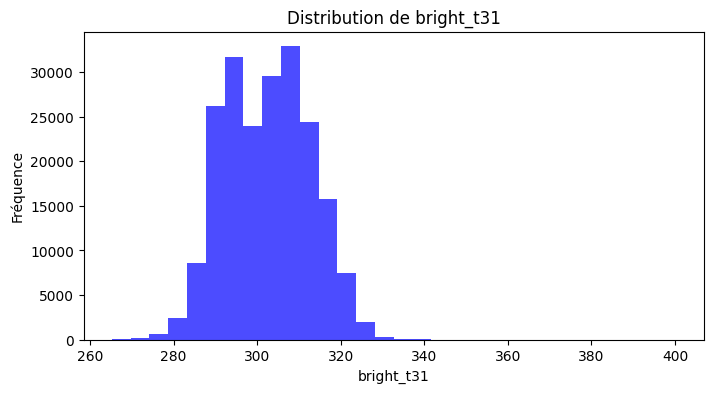

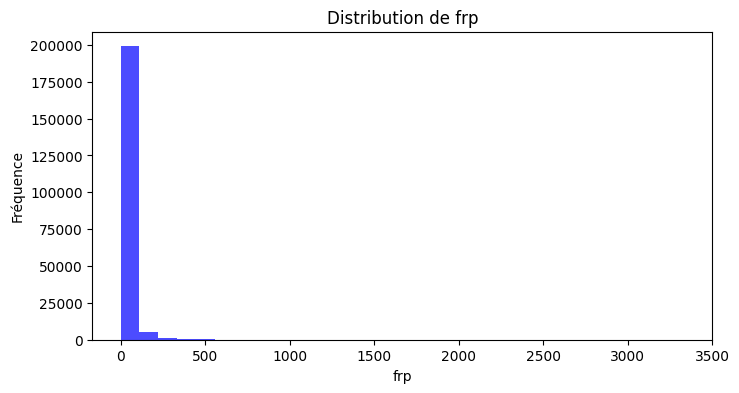

In [21]:
# 4. Présentation des variables quantitatives
# Sélectionner les colonnes quantitatives
quantitative_columns = ['brightness', 'scan', 'track', 'confidence', 'bright_t31', 'frp']

# Afficher des graphiques pour les variables quantitatives
for col in quantitative_columns:
    plt.figure(figsize=(8, 4))
    plt.hist(df_cleaned[col], bins=30, color='blue', alpha=0.7)
    plt.title(f'Distribution de {col}')
    plt.xlabel(col)
    plt.ylabel('Fréquence')
    plt.show()

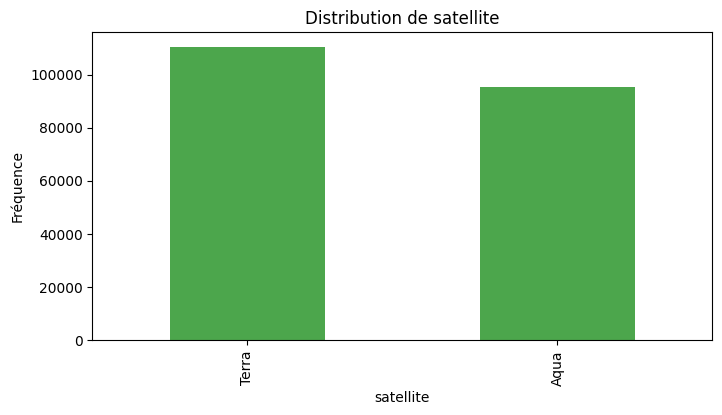

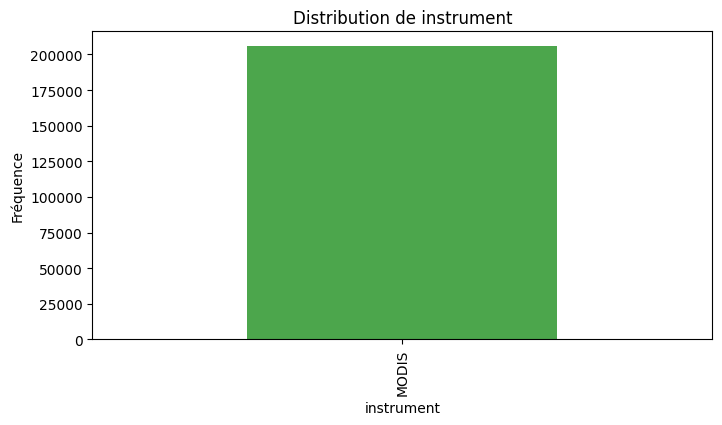

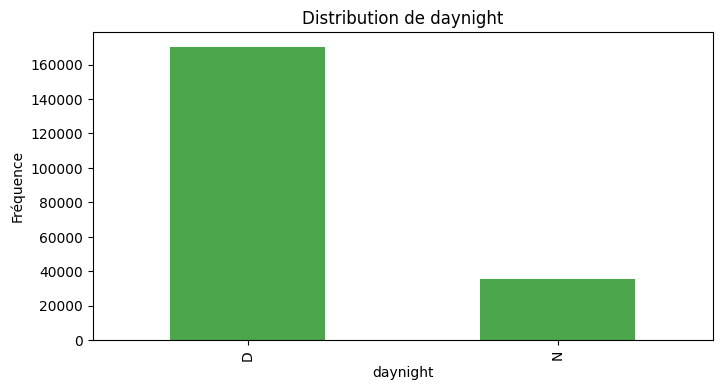

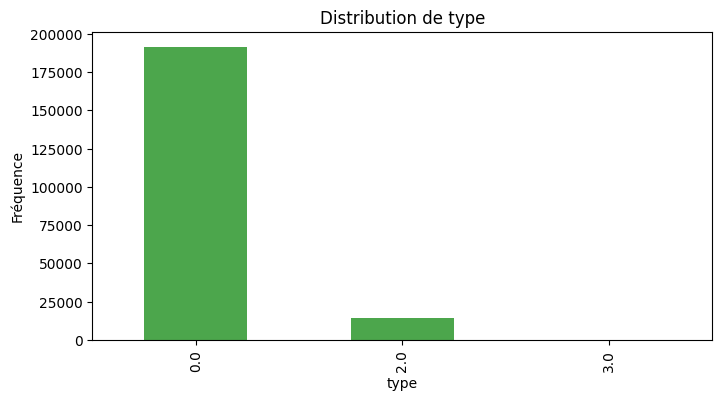


Valeurs uniques pour satellite:
['Terra' 'Aqua']

Valeurs uniques pour instrument:
['MODIS']

Valeurs uniques pour daynight:
['D' 'N']

Valeurs uniques pour type:
[0. 2. 3.]


In [22]:
# 5. Présentation des variables qualitatives
# Sélectionner les colonnes qualitatives
qualitative_columns = ['satellite', 'instrument', 'daynight', 'type']

# Afficher des graphiques pour les variables qualitatives
for col in qualitative_columns:
    plt.figure(figsize=(8, 4))
    df_cleaned[col].value_counts().plot(kind='bar', color='green', alpha=0.7)
    plt.title(f'Distribution de {col}')
    plt.xlabel(col)
    plt.ylabel('Fréquence')
    plt.show()

# Afficher les valeurs uniques pour chaque variable qualitative
for col in qualitative_columns:
    print(f"\nValeurs uniques pour {col}:")
    print(df_cleaned[col].unique())

In [23]:
# 6. Évolution des feux au fil des années
# Extraire l'année de la colonne 'acq_date'
df_cleaned['year'] = pd.to_datetime(df_cleaned['acq_date']).dt.year

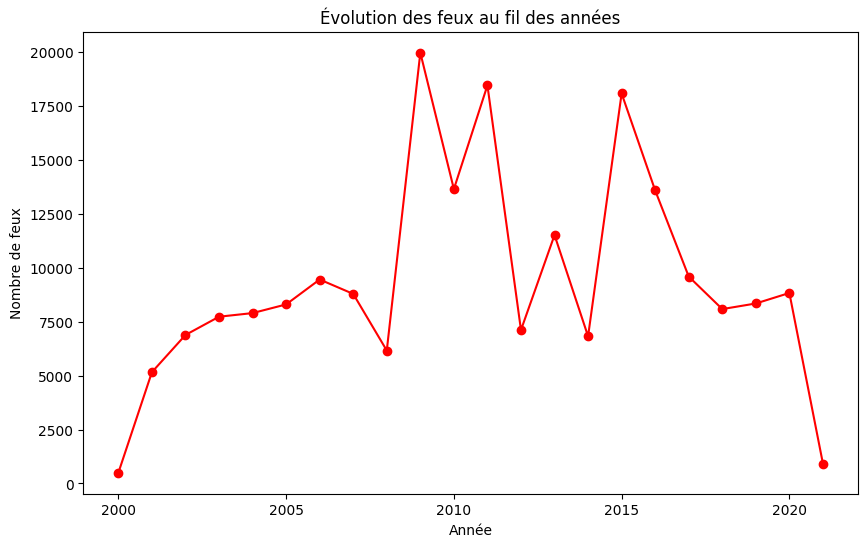

In [24]:
# Afficher un graphique de l'évolution des feux au fil des années
plt.figure(figsize=(10, 6))
df_cleaned.groupby('year').size().plot(kind='line', marker='o', color='red')
plt.title('Évolution des feux au fil des années')
plt.xlabel('Année')
plt.ylabel('Nombre de feux')
plt.show()

In [25]:
# 7. Préparation des données
features = ['latitude', 'longitude', 'brightness', 'scan', 'track', 'confidence', 'bright_t31', 'frp', 'satellite', 'instrument', 'daynight']
df_known = df_cleaned[df_cleaned['type'].notna()]
df_unknown = df_cleaned[df_cleaned['type'].isna()]
X = df_known[features]
y = df_known['type']

encoder = OneHotEncoder(drop='first', sparse_output=False)
X_encoded = encoder.fit_transform(X[['satellite', 'instrument', 'daynight']])
encoded_feature_names = encoder.get_feature_names_out(['satellite', 'instrument', 'daynight'])

X_numeric = X.drop(['satellite', 'instrument', 'daynight'], axis=1).reset_index(drop=True)
X_final = pd.concat([X_numeric, pd.DataFrame(X_encoded, columns=encoded_feature_names)], axis=1)


In [26]:
# 8. Division des données
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)


In [27]:
# 9. Entraînement du modèle
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [28]:
# 10. Évaluation
y_pred = model.predict(X_test)
print("Précision du modèle :", accuracy_score(y_test, y_pred))
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))


Précision du modèle : 0.9711538461538461

Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     38353
         2.0       0.92      0.64      0.75      2814
         3.0       1.00      0.29      0.45        17

    accuracy                           0.97     41184
   macro avg       0.97      0.64      0.73     41184
weighted avg       0.97      0.97      0.97     41184



In [29]:
# Vérifier si df_unknown contient des données
if not df_unknown.empty:
    # Remplir les valeurs manquantes dans les colonnes nécessaires
    df_unknown[['satellite', 'instrument', 'daynight']] = df_unknown[['satellite', 'instrument', 'daynight']].fillna('Unknown')
    
    # Sélectionner les features pour l'encodage
    X_unknown = df_unknown[features]

    # Encoder les colonnes catégorielles avec OneHotEncoder
    X_unknown_encoded = encoder.transform(X_unknown[['satellite', 'instrument', 'daynight']])

    # Supprimer les colonnes encodées et garder les autres variables numériques
    X_unknown_numeric = X_unknown.drop(['satellite', 'instrument', 'daynight'], axis=1).reset_index(drop=True)

    # Combiner les variables numériques et encodées
    X_unknown_final = pd.concat([X_unknown_numeric, pd.DataFrame(X_unknown_encoded, columns=encoded_feature_names)], axis=1)

    # Prédire les types de feu pour les données inconnues
    predicted_types = model.predict(X_unknown_final)

    # Ajouter les prédictions dans la colonne 'type'
    df_unknown['type'] = predicted_types

    # Combiner les données connues et inconnues
    df_final = pd.concat([df_known, df_unknown], axis=0)

else:
    print("Aucune donnée disponible pour les types de feu inconnus.")
    # Si df_unknown est vide, seulement df_known est utilisé
    df_final = df_known

# Vérification de df_final
print(f"df_final contains {df_final.shape[0]} rows")

Aucune donnée disponible pour les types de feu inconnus.
df_final contains 205918 rows


In [30]:
# Charger et filtrer les données (confiance > 90%)
df_filtered = df_cleaned[df_cleaned['confidence'] > 90]

# S'assurer que la colonne de date est bien en format datetime
df_filtered['acq_date'] = pd.to_datetime(df_filtered['acq_date'])  

# Extraire l'année des incendies
df_filtered['year'] = df_filtered['acq_date'].dt.year

# Créer la carte centrée sur la Turquie
m = folium.Map(location=[39, 35], zoom_start=6)

# Créer un dictionnaire pour stocker les groupes par année
year_groups = {}

# Ajouter chaque incendie dans un cluster correspondant à son année
for year in df_filtered['year'].unique():
    # Créer un groupe avec clustering
    cluster = MarkerCluster(name=f"Incendies {year}").add_to(m)
    
    # Filtrer les incendies pour cette année
    df_year = df_filtered[df_filtered['year'] == year]
    
    # Ajouter les points à ce cluster
    for _, row in df_year.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=4,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.6,
            popup=f"Année: {year}, Confiance: {row['confidence']}"
        ).add_to(cluster)

# Ajouter un contrôle pour activer/désactiver les couches par année
folium.LayerControl(collapsed=False).add_to(m)

# Sauvegarde de la carte
m.save("fire_map_by_year_clustered.html")
print("✅ Carte interactive enregistrée sous 'fire_map_by_year_clustered.html'.")


C:\Users\amaur\AppData\Local\Temp\ipykernel_21780\2792712082.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['acq_date'] = pd.to_datetime(df_filtered['acq_date'])
C:\Users\amaur\AppData\Local\Temp\ipykernel_21780\2792712082.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['year'] = df_filtered['acq_date'].dt.year


✅ Carte interactive enregistrée sous 'fire_map_by_year_clustered.html'.
